Copyright (c) 2024 Microsoft Corporation.

Licensed under the MIT License

Perform TARDIS on FTW
- Define ID and WILD dataloaders
- Form and apply the TARDIS pipeline on the pretrained FTW model
- Plot f, g distribution on map
- Plot the activation space of g
- Plot f, g predictions

In [26]:
import os
import pprint
from datetime import datetime
from pathlib import Path

import numpy as np
import pandas as pd
import torch
import yaml
from custom_trainer import CustomSemanticSegmentationTask
from data_utils import (FTWDataModuleOOD, WILDGeoTIFFDataset,
                        process_ID_dataloader, process_WILD_dataloader)
from scipy.stats import skew
from tardis_wrapper import OODModelWrapper, get_model_layers
from torch.utils.data import DataLoader
from utils import (calculate_metrics, correlation_analysis, extract_data,
                   load_config, load_data_dict_from_pkl, percentile_stretch,
                   plot_f_and_g_preds_probab,
                   plot_g_prob_distribution_w_skewness,
                   plot_histograms_for_countries, plot_ID_surrID_surrOOD,
                   plot_ID_WILD, plot_tsne, save_data_dict_as_pkl,
                   visualize_data)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# Load configuration from YAML file
config = load_config()

# Extract base directory
base_dir = Path(config["base_dir"])

# Define paths using the base directory and paths from the config
model_checkpoint = base_dir / config["paths"]["model_checkpoint"]
root_folder_torchgeo = base_dir / config["paths"]["root_folder_torchgeo"]
path_wild_patches = base_dir / config["paths"]["path_wild_patches"]

# Construct Dataloaders parameters from config
batch_size = config["dataloader"]["batch_size"]
num_workers = config["dataloader"]["num_workers"]
sample_N_from_each_country = config["dataloader"]["sample_N_from_each_country"]
all_countries = config["dataloader"]["all_countries"]
val_countries = config["dataloader"]["val_countries"]
test_countries = config["dataloader"]["test_countries"]
target = config["dataloader"]["target"]

# Wrap the model with OOD detector parameters from config
chosen_layer = config["ood_detector"]["chosen_layer"]
resize_factor = config["ood_detector"]["resize_factor"]
id_fraction_thr = config["ood_detector"]["id_fraction_thr"]
n_batches_to_process = config["ood_detector"]["n_batches_to_process"]
random_state = config["ood_detector"]["random_state"]
estimators = config["ood_detector"]["estimators"]
test_size = config["ood_detector"]["test_size"]
use_optuna = config["ood_detector"]["use_optuna"]
patch_size = config["ood_detector"]["patch_size"]
device = "cuda" if torch.cuda.is_available() else "cpu"

# Print paths for verification
print(f"Model checkpoint path: {model_checkpoint.resolve()}")
print(f"Root folder for TorchGeo: {root_folder_torchgeo.resolve()}")
print(f"Path to wild patches: {path_wild_patches.resolve()}")

In [ ]:
task = CustomSemanticSegmentationTask.load_from_checkpoint(
    model_checkpoint, map_location="cpu"
)
task.freeze()
model = task.model
model = model.eval().to(device)

layer_names = get_model_layers(model)

Using custom trainer
"backbone":        efficientnet-b3
"class_weights":   [0.04, 0.08, 0.88]
"freeze_backbone": False
"freeze_decoder":  False
"ignore_index":    3
"in_channels":     8
"loss":            ce
"lr":              0.001
"model":           unet
"model_kwargs":    {}
"num_classes":     3
"num_filters":     64
"patch_weights":   False
"patience":        100


ID Dataloader

In [ ]:
FTWDatamoduleOOD = FTWDataModuleOOD(
    root_folder_torchgeo,
    batch_size=batch_size,
    num_workers=num_workers,
    train_countries=all_countries,
    val_countries=val_countries,
    test_countries=test_countries,
    download=True,
    sample_N_from_each_country=sample_N_from_each_country,
    target=target,
)

FTWDatamoduleOOD.setup(stage="fit")
id_train_dataloader = FTWDatamoduleOOD.train_dataloader()
val_dataloader = FTWDatamoduleOOD.val_dataloader()
FTWDatamoduleOOD.setup(stage="test")
test_dataloader = FTWDatamoduleOOD.test_dataloader()

print("len train samples", len(id_train_dataloader.dataset))
print("len val samples", len(val_dataloader.dataset))
print("len test samples", len(test_dataloader.dataset))
print(next(iter(id_train_dataloader))["image"].shape)
print("DataModule setup complete.")

Loaded datamodule with:
Train countries: ['belgium', 'cambodia', 'croatia', 'estonia', 'portugal', 'slovakia', 'south_africa', 'sweden', 'austria', 'brazil', 'corsica', 'denmark', 'france', 'india', 'latvia', 'luxembourg', 'finland', 'germany', 'kenya', 'lithuania', 'netherlands', 'rwanda', 'slovenia', 'spain', 'vietnam']
Val countries: ['portugal', 'germany']
Test countries: ['rwanda', 'slovenia']
Sampling 20 samples from country 'belgium'
Sampling 20 samples from country 'cambodia'
Sampling 20 samples from country 'croatia'
Sampling 20 samples from country 'estonia'
Sampling 20 samples from country 'portugal'
Sampling 20 samples from country 'slovakia'
Sampling 20 samples from country 'south_africa'
Sampling 20 samples from country 'sweden'
Sampling 20 samples from country 'austria'
Sampling 20 samples from country 'brazil'
Sampling 20 samples from country 'corsica'


Sampling 20 samples from country 'denmark'
Sampling 20 samples from country 'france'
Sampling 20 samples from country 'india'
Sampling 20 samples from country 'latvia'
Sampling 20 samples from country 'luxembourg'
Sampling 20 samples from country 'finland'
Sampling 20 samples from country 'germany'
Sampling 20 samples from country 'kenya'
Sampling 20 samples from country 'lithuania'
Sampling 20 samples from country 'netherlands'
Sampling 20 samples from country 'rwanda'
Sampling 20 samples from country 'slovenia'
Sampling 20 samples from country 'spain'
Sampling 20 samples from country 'vietnam'
Train dataset: 491 for the countries ['belgium', 'cambodia', 'croatia', 'estonia', 'portugal', 'slovakia', 'south_africa', 'sweden', 'austria', 'brazil', 'corsica', 'denmark', 'france', 'india', 'latvia', 'luxembourg', 'finland', 'germany', 'kenya', 'lithuania', 'netherlands', 'rwanda', 'slovenia', 'spain', 'vietnam']
Val dataset: 39 for the countries ['portugal', 'germany']
Test dataset: 235 f

WILD Dataloader

In [12]:
wild_dataset = WILDGeoTIFFDataset(directory=path_wild_patches)
wild_data_loader = DataLoader(wild_dataset, batch_size=batch_size, shuffle=False)

print("len(dataset):", len(wild_data_loader.dataset))
print(next(iter(wild_data_loader))["image"].shape)
len(wild_dataset.coords), len(wild_dataset.valid_pairs)

 - 62800_T48VXK_harvesting.tif coords: tensor([ 58.3147, 107.2775])
 - 62800_T38LQH_planting.tif coords: tensor([-15.5465,  47.6898])
len(dataset): 1150
torch.Size([8, 8, 256, 256])


(1150, 1150)

Form the Pipeline

In [16]:
num_clusters = int(0.3 * len(id_train_dataloader.dataset))

ood_model = OODModelWrapper(
    base_model=model,
    hook_layer_name=chosen_layer,
    main_loader=FTWDatamoduleOOD,
    id_loader=id_train_dataloader,
    wild_loader=wild_data_loader,
    n_batches_to_process=n_batches_to_process,
    test_size=test_size,
    use_optuna=False,
    num_clusters=num_clusters,
    M=id_fraction_thr,
    random_state=random_state,
    n_estimators=estimators,
    resize_factor=resize_factor,
    patch_size=patch_size,
    device=device,
    classifier_save_path="ood_classifier.pkl",
)

print("number of ID samples", len(id_train_dataloader.dataset))
print("number of WILD samples", len(wild_data_loader.dataset))
print("Chosen layer:", chosen_layer)
print("Number of clusters:", num_clusters)

OOD classifier loaded from ood_classifier.pkl
number of ID samples 491
number of WILD samples 1150
Chosen layer: decoder.blocks.0.conv1
Number of clusters: 147


Apply TARDIS:
- Compute features
- Apply surrogate label assignment 
- Train the classifier g

In [17]:
if hasattr(ood_model.ood_classifier, "classes_"):
    print("'g' is already loaded.")
    pass
else:
    print("'g' is not loaded.")
    # Compute features
    X, y = ood_model.compute_features()
    # Feature space clustering
    y_clustered = ood_model.feature_space_clustering(X, y)
    # Classification
    metrics = ood_model.g_classification(X, y_clustered)
    # Print metrics if training a classifier
    pprint.pprint(metrics)

'g' is already loaded.


Collect ID 

In [18]:
ID_all = process_ID_dataloader(
    id_train_dataloader,
    ood_model,
    return_batch=True,
    return_f_pred=True,
    return_g_pred=True,
    return_thresholded_g_pred=False,
    return_coords=True,
    return_masks=True,
    upsample=True,
    max_batches=None,
)

  0%|          | 0/61 [00:00<?, ?it/s]

100%|██████████| 61/61 [00:51<00:00,  1.18it/s]


Collect WILD

In [19]:
WILD_all = process_WILD_dataloader(
    wild_data_loader,
    ood_model,
    return_batch=True,
    return_f_pred=True,
    return_g_pred=True,
    return_thresholded_g_pred=False,
    return_coords=True,
    upsample=True,
    max_batches=None,
)

  0%|          | 0/144 [00:00<?, ?it/s]

100%|██████████| 144/144 [01:09<00:00,  2.06it/s]


Sanity check

In [20]:
try:
    if y is not None:
        y_uniq, y_counts = np.unique(y, return_counts=True)
        print(
            "There are {unique} unique clusters with counts {counts}".format(
                unique=len(y_uniq), counts=dict(zip(y_uniq, y_counts))
            )
        )
        print("X .shape:", X.shape)
        y_clustered_uniq, y_clustered_counts = np.unique(
            y_clustered, return_counts=True
        )
        print(
            "There are {unique} unique clusters with counts {counts}".format(
                unique=len(y_clustered_uniq),
                counts=dict(zip(y_clustered_uniq, y_clustered_counts)),
            )
        )
except NameError:
    print("Variable 'y' or 'y_clustered' is not defined.")

Variable 'y' or 'y_clustered' is not defined.


### Plot on map: ID and WILD

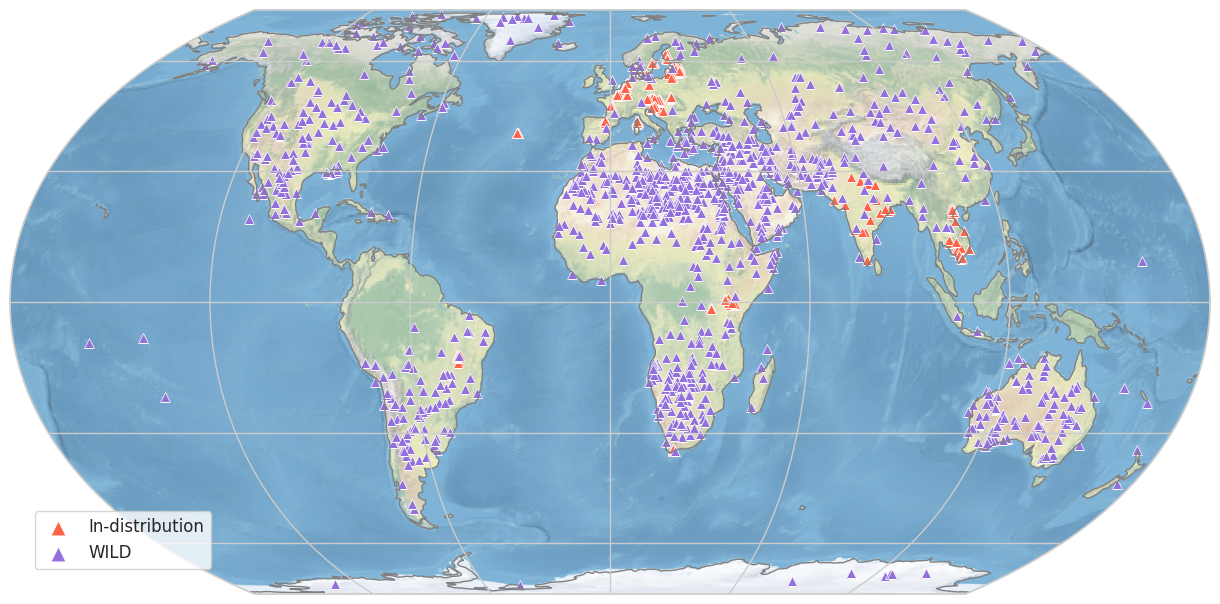

In [ ]:
plot_ID_WILD(
    ID_all,
    WILD_all,
    save=True,
    file_format="svg",
    dpi=200,
    filepath="./plots",
    filename="on_map_id_wild",
)

### Plot the activation space: "X" in 2D, labelled with y (ID/WILD labels) and y_clustered (Surrogate ID and Surrogate OOD labels)

In [22]:
try:
    plot_tsne(X, y, y_clustered)

except NameError:
    print("Variable 'y' or 'y_clustered' is not defined.")

Variable 'y' or 'y_clustered' is not defined.


### Plot on map: ID and WILD breakdown into surrogate ID and surrogate OOD

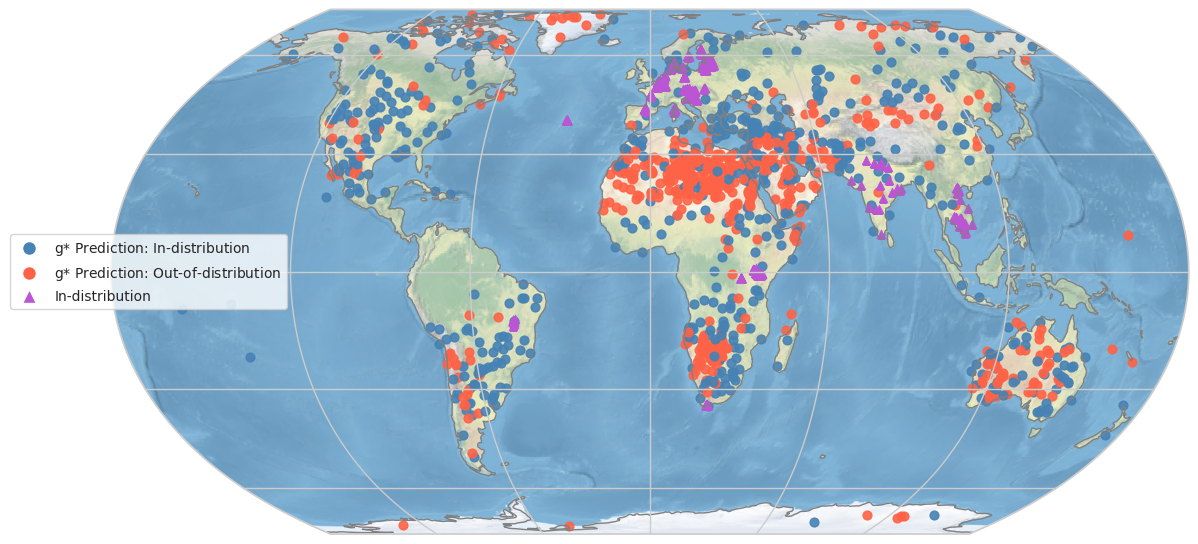

In [23]:
plot_ID_surrID_surrOOD(
    WILD_all,
    ID_all,
    save=True,
    file_format="svg",
    dpi=200,
    filepath="./plots",
    filename="on_map_id_surrID_surrOOD",
)

### g(WILD) probabilities in a Histogram

Skewness of g_pred over WILD data 0.07407576770757542


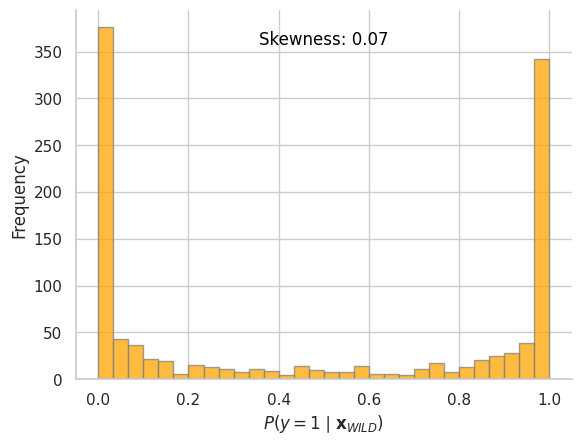

In [24]:
skew_prob = skew(WILD_all["g_pred_probs"])
print("Skewness of g_pred over WILD data", skew_prob)

plot_g_prob_distribution_w_skewness(
    WILD_all["g_pred_probs"], suffix="WILD", skewness_value=skew_prob, save_plot=False
)

### g and f(FTW_{train}^country[i])

In [ ]:
dataloader_factory = {}
max_batches = None
batch_size = 6
num_workers = os.cpu_count()

for country in all_countries:
    batch_size = batch_size
    num_workers = num_workers
    sample_N_from_each_country = None
    FTWDatamoduleOOD = FTWDataModuleOOD(
        root_folder_torchgeo,
        batch_size=batch_size,
        num_workers=num_workers,
        train_countries=None,
        val_countries=None,
        test_countries=country,
        download=False,
        sample_N_from_each_country=sample_N_from_each_country,
        target=target,
    )

    FTWDatamoduleOOD.setup(stage="test")
    test_dataloader = FTWDatamoduleOOD.test_dataloader()
    dataloader_factory[country] = test_dataloader


country_results = {}
metrics_dict = {}

for country in tqdm.tqdm(all_countries):
    print("Country:", country)

    testset_id_dataloader = dataloader_factory[country]

    return_f_pred = True
    return_g_pred = True
    return_thresholded_g_pred = False
    return_coords = True
    return_masks = True
    upsample = True
    max_batches = max_batches

    ID_all = process_ID_dataloader(
        testset_id_dataloader,
        ood_model,
        return_f_pred=return_f_pred,
        return_g_pred=return_g_pred,
        return_thresholded_g_pred=return_thresholded_g_pred,
        return_coords=return_coords,
        return_masks=return_masks,
        upsample=upsample,
        max_batches=max_batches,
    )

    f_preds_single_channel = ID_all["f_preds"]
    g_pred_probs_testsetid = ID_all["g_pred_probs"]
    true_masks_all = ID_all["masks"]
    id_coords_all = ID_all["coords"]

    metrics = calculate_metrics(true_masks_all, f_preds_single_channel)

    country_results[country] = {
        "f_preds_testsetid": f_preds_single_channel,
        "g_pred_probs_testsetid": g_pred_probs_testsetid,
        "true_masks": true_masks_all,
        "coords": id_coords_all,
        "metrics": metrics,
    }

    # Clean up
    del f_preds_single_channel, g_pred_probs_testsetid, id_coords_all, true_masks_all
    torch.cuda.empty_cache()

Export the dict

In [ ]:
save = False

In [ ]:
if save:
    file_path = "./pickles/id_data_dict.pkl"
    save_data_dict_as_pkl(country_results, file_path)

Hist for all Countries

In [ ]:
if save:
    load_data_dict_from_pkl("./pickles/id_data_dict.pkl")

In [ ]:
plot_histograms_for_countries(country_results, metric="f1")

In [ ]:
# Step 1: Extract Data
df = extract_data(country_results)
print(df)

# Step 2: Visualization
visualize_data(df, save_plot=True)

# Step 3: Correlation Analysis
correlation_analysis(df)

### Input, g, and f preds of 10 Percentiles: lowest, mid and top. Plot and save them all 

In [ ]:
# Step 1: Sort the array and get the corresponding indexes
sorted_indexes = np.argsort(WILD_all["g_pred_probs"])

# Step 2: Determine the percentile ranges
n = len(WILD_all["g_pred_probs"])
lowest_10_percentile_indexes = sorted_indexes[: int(0.1 * n)]
mid_10_percentile_start = int(0.45 * n)
mid_10_percentile_end = int(0.55 * n)
mid_10_percentile_indexes = sorted_indexes[
    mid_10_percentile_start:mid_10_percentile_end
]
top_10_percentile_indexes = sorted_indexes[-int(0.1 * n) :]

print("Indexes of the lowest 10 percentile values:", lowest_10_percentile_indexes)
print("Indexes of the middle 10 percentile values:", mid_10_percentile_indexes)
print("Indexes of the top 10 percentile values:", top_10_percentile_indexes)

In [ ]:
idx = lowest_10_percentile_indexes[71]
coord = WILD_all["coords"][idx]
g_pred_prob_wild = WILD_all["g_pred_probs"][idx]

window_a = percentile_stretch(WILD_all["batch"][idx, :3, :, :].permute(1, 2, 0))
window_b = percentile_stretch(WILD_all["batch"][idx, 4:-1, :, :].permute(1, 2, 0))

f_pred_permuted = WILD_all["f_preds"][idx]

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
fname = f"{g_pred_prob_wild}_WILD_{idx}_{timestamp}.png"
plot_f_and_g_preds_probab(window_a, window_b, g_pred_prob_wild, f_pred_permuted)

Save the percentiles in three diff folders

In [ ]:
percentiles_dict = {
    "lowest_10": lowest_10_percentile_indexes,
    "mid_10": mid_10_percentile_indexes,
    "top_10": top_10_percentile_indexes,
}

In [ ]:
num_samples_to_process = len(percentiles_dict["lowest_10"])

for perc_name, percentile_idx in percentiles_dict.items():
    sample_count = 0
    for idx in percentile_idx:
        if sample_count >= num_samples_to_process:
            break

        coord = WILD_all["coords"][idx]
        g_pred_prob_wild = WILD_all["g_pred_probs"][idx]

        window_a = percentile_stretch(WILD_all["batch"][idx, :3, :, :].permute(1, 2, 0))
        window_b = percentile_stretch(
            WILD_all["batch"][idx, 4:-1, :, :].permute(1, 2, 0)
        )

        f_pred_permuted = WILD_all["f_preds"][idx]

        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        fname = f"{perc_name}_{g_pred_prob_wild}_WILD_{idx}_{timestamp}.png"

        plot_f_and_g_preds_probab(
            window_a,
            window_b,
            g_pred_prob_wild,
            f_pred_permuted,
            "./deploy_ftw_figs/ups2_all_new_png_2",
            fname,
        )

        sample_count += 1